In [4]:
from __future__ import print_function
from pixell import enmap,utils, reproject, enplot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os,sys
import urllib.request
from scipy import interpolate
from scipy.stats import norm
import csv
import yaml
from astropy.convolution import Gaussian2DKernel, convolve
from astropy.modeling import models, fitting
import astropy.units as u
from astropy.io import fits
from astropy.table import QTable
from astroquery.esasky import ESASky
from astropy.nddata import Cutout2D
from astropy import wcs
import pickle as pk


%matplotlib inline

In [5]:
def central_emission(hmap, map_w, pixel_w, max_sep):
    #Returns the average surface brightness in Jy/pixel of pixels within max_sep of the center of hmap (assuming hmap has units MJy/pixel)
    center = map_w + 0.5
    
    emission = 0
    div = 0
    
    for i in range(2*map_w):
        for j in range(2*map_w):
            if pixel_w*np.sqrt((center-i)**2+(center-j)**2) <= max_sep:
                emission += hmap[i,j]
                div +=1
    return emission, div

In [6]:
def hersch_stacker(hmap, freq, ras, decs, width):
    stack = 0
    divisor = 0
    width = int(width)
    freq = freq
    hmap = hmap
    
    print(freq,hmap)

    hi_data = fits.open('/project/r/rbond/jorlo/herschel_maps/HATLAS/HATLAS_{}_BACKSUB{}.FITS'.format(hmap,freq))
    w = wcs.WCS(hi_data[0].header)
    for i in range(len(ras)):
        px, py = w.wcs_world2pix(ras[i], decs[i], 1)
        if np.isnan(px) or np.isnan(py) or ((px+width) >hi_data[0].data.shape[0]) or ((py+width) > hi_data[0].data.shape[0]):
            continue
        px = np.round(px).astype(int)
        py = np.round(py).astype(int)
        try:
            cutout = Cutout2D(hi_data[0].data, (px,py), width *2, mode = 'strict')
        except:
            continue
        stamp = cutout.data

        if not np.any(stamp):
            continue
    
        if stamp.shape != (2*width, 2*width):
            continue

        stack += stamp
        divisor += 1

    if divisor == 0:
        return
    stack /= divisor

    fig = plt.figure()

    bound = width*0.001667*60

    plt.imshow(stack, origin='lower', cmap=plt.cm.viridis, extent = [-bound,bound, -bound,bound])
    plt.colorbar()
    plt.title('MaDCoWS Clusters in {} {} $\mu$m \n {} in stack'.format(hmap, freq, divisor))
    plt.xlabel('RA (arcmin)')
    plt.ylabel('Dec (arcmin)')
    plt.savefig('./plots/herschel/{}_{}_mdcw.pdf'.format(hmap, freq))
    plt.savefig('./plots/herschel/{}_{}_mdcw.png'.format(hmap, freq), dpi = 300)
    plt.show()
    plt.close()

In [7]:
def filt_hersch_stacker(hmap, freq, ras, decs, width):
    stack = 0
    divisor = 0
    width = int(width)
    freq = freq
    hmap = hmap
    
    print(freq,hmap)

    hi_data = fits.open('/project/r/rbond/jorlo/herschel_maps/HATLAS/filtered/HATLAS_{}_FILT_BACKSUB{}.FITS'.format(hmap,freq))
    w = wcs.WCS(hi_data[0].header)
    for i in range(len(ras)):
        px, py = w.wcs_world2pix(ras[i], decs[i], 1)
        if np.isnan(px) or np.isnan(py) or ((px+width) >hi_data[0].data.shape[0]) or ((py+width) > hi_data[0].data.shape[0]):
            continue
        px = np.round(px).astype(int)
        py = np.round(py).astype(int)
        try:
            cutout = Cutout2D(hi_data[0].data, (px,py), width *2, mode = 'strict')
        except:
            continue
        stamp = cutout.data

        if not np.any(stamp):
            continue
    
        if stamp.shape != (2*width, 2*width):
            continue
        
        stack += stamp
        divisor += 1

    if divisor == 0:
        return
    stack /= divisor

    fig = plt.figure()

    bound = width*0.001667*60

    plt.imshow(stack, origin='lower', cmap=plt.cm.viridis, extent = [-bound,bound, -bound,bound])
    plt.colorbar()
    plt.title('MaDCoWS Clusters in {} Filtered {} $\mu$m \n {} in stack'.format(hmap, freq, divisor))
    plt.xlabel('RA (arcmin)')
    plt.ylabel('Dec (arcmin)')
    plt.scatter(0,0, marker = '+', color = 'r')
    plt.savefig('./plots/herschel/filt_{}_{}_mdcw.pdf'.format(hmap, freq))
    plt.savefig('./plots/herschel/filt_{}_{}_mdcw.png'.format(hmap, freq), dpi = 300)
    plt.show()
    plt.close()
    
    cent_scale = 4
    
    center_mean = np.mean(stack[width - cent_scale:width + cent_scale -1,width - cent_scale:width + cent_scale -1])
                            
    print('{} Filtered {} $\mu$m has mean {}'.format(hmap, freq, center_mean))

In [32]:
def filt_full_hersch_stacker(freq, ras, decs, name, clusternames, weight = True, width = 50., zs = None, plot = True):
    stack = 0
    z = 0
    zdiv = 0
    divisor = 0
    width = int(width)
    freq = freq
    name = str(name)
    
    #Poorly named variable: not the beam size but the aperture over which we average emission and associate with a cluster
    beam = 2.4
    
    #print(freq)
    return_names = []
    hmaps = ['GAMA12_DR1','GAMA15_DR1', 'GAMA9_DR1', 'NGP_DR2', 'SGP_DR2']

    for hmap in hmaps:
        #Gama12 250 header currently bugged, temporarily just skip
        #if freq == '250' and hmap == 'GAMA12_DR1':
        #    continue

        print('Loading map {} {}'.format(hmap, freq), end = '\r')
        hi_data = fits.open('/project/r/rbond/jorlo/herschel_maps/HATLAS/smoothed/HATLAS_{}_FILT_BACKSUB{}_1.0SMOOTH.fits'.format(hmap,freq))
        
        w = wcs.WCS(hi_data[0].header)
        #print('Map {} {} loaded'.format(hmap, freq), end = '\r')
        
        hdata = hi_data[0].data
        
        for i in range(len(ras)):
            print(round(i/len(ras),2), end =  '\r')
            px, py = w.wcs_world2pix(ras[i], decs[i], 1)
            if np.isnan(px) or np.isnan(py) or ((px+width) >hi_data[0].data.shape[0]) or ((py+width) > hi_data[0].data.shape[0]):
                continue
            px = np.round(px).astype(int)
            py = np.round(py).astype(int)
            try:
                cutout = Cutout2D(hdata, (px,py), width *2, mode = 'strict')
            except:
                continue
            stamp = cutout.data

            if not np.any(stamp):
                continue
            if stamp[width, width] ==0:
                continue
            if stamp.shape != (2*width, 2*width):
                continue
            
            if weight:
            
                weight_data = fits.open('/project/r/rbond/jorlo/herschel_maps/HATLAS/filtered/HATLAS_{}_FILT_SIGMA{}.FITS'.format(hmap,freq))
                weight_w = wcs.WCS(weight_data[0].header)

                weight_px, weight_py = weight_w.wcs_world2pix(ras[i], decs[i], 1)
                weight_px = np.round(weight_px).astype(int)
                weight_py = np.round(weight_py).astype(int)

                weight_val = weight_data[0].data[weight_px,weight_py]

                if weight_val <= 10**-20:
                    continue
            else:
                weight_val = 1

            if zs is not None:
                if zs[i] < 100 and not np.isnan(zs[i]):
                    z += zs[i]
                    zdiv += 1
            
            stack += stamp/weight_val
            divisor += 1/weight_val
            return_names.append(clusternames[i])


    if divisor == 0:
        return
    stack /= divisor
    if zdiv != 0:
        z/= zdiv
    else:
        z = None
    print(divisor)
        
    #Calculate mean surface brighness within 0.9' and convert from MJy/beam to MJy/sr

    
    header = hi_data[0].header

    cdelt = header.get('CDELT2', 1.0)

    pixel_size = cdelt*60*u.arcmin

    em, num = central_emission(stack, 50, pixel_size.value, beam/2)

    em = em*u.Jy
    em = em.to(u.MJy)

    pixel_area = ((pixel_size)**2).to(u.sr)


    mean_cent_em = em/(num*pixel_area)
    map_var_Jy = np.std(stack[60:99, 0:99]/pixel_area.value)*u.Jy/pixel_area.unit
    map_var = (map_var_Jy).to(u.MJy/u.sr) 
    
    if plot:
    
        #Plot the stack
        fig, axes = plt.subplots()

        bound = width*pixel_size.value

        plt.imshow(stack, origin='lower', cmap=plt.cm.viridis, extent = [-bound,bound, -bound,bound])
        plt.colorbar()

        plt.title('{} Clusters at {} $\mu$m, {} in Stack  with z = {:0.3}\n {:0.2e} $\pm$ {:0.2e} MJy/sr central emission'.format(name, 
                                                freq, divisor, z, mean_cent_em.value, map_var.value))
        plt.xlabel('RA (arcmin)')
        plt.ylabel('Dec (arcmin)')
        #plt.scatter(0,0, marker = '+', color = 'r')
        draw_circle = plt.Circle((0, 0), beam/2, color = 'r',fill=False, alpha = 0.5)
        axes.set_aspect(1)
        axes.add_artist(draw_circle)

        plt.savefig('./plots/herschel/smooth_1.0_full_filt_{}_{}.pdf'.format(freq, name))
        plt.savefig('./plots/herschel/smooth_1.0_full_filt_{}_{}.png'.format(freq, name), dpi = 300)

        plt.show()
        plt.close()


                            
    #print('Filtered {} $\mu$m has mean {}'.format(freq, center_mean))
    return stack, mean_cent_em, map_var, return_names

In [9]:
def hersch_stamper(freq, ras, decs, width, names):

    stack = 0
    z = 0
    zdiv = 0
    divisor = 0
    width = int(width)
    freq = freq
    stamps = {}

    #print(freq)
    
    hmaps = ['GAMA12_DR1','GAMA15_DR1', 'GAMA9_DR1', 'NGP_DR2', 'SGP_DR2']

    for hmap in hmaps:
        #Gama12 250 header currently bugged, temporarily just skip
        if freq == '250' and hmap == 'GAMA12_DR1':
            continue

        #print('Loading map {} {}'.format(hmap, freq), end = '\r')
        hi_data = fits.open('/project/r/rbond/jorlo/herschel_maps/HATLAS/smoothed/HATLAS_{}_FILT_BACKSUB{}_1.0SMOOTH.fits'.format(hmap,freq))
        
        w = wcs.WCS(hi_data[0].header)
        #print('Map {} {} loaded'.format(hmap, freq), end = '\r')
        
        hdata = hi_data[0].data
        
        for i in range(len(ras)):
            print(round(i/len(ras),2), end =  '\r')
            px, py = w.wcs_world2pix(ras[i], decs[i], 1)
            if np.isnan(px) or np.isnan(py) or ((px+width) >hi_data[0].data.shape[0]) or ((py+width) > hi_data[0].data.shape[0]):
                continue
            px = np.round(px).astype(int)
            py = np.round(py).astype(int)
            try:
                cutout = Cutout2D(hdata, (px,py), width *2, mode = 'strict')
            except:
                continue
            stamp = cutout.data

            if not np.any(stamp):
                continue
            if stamp[width, width] ==0:
                continue
            if stamp.shape != (2*width, 2*width):
                continue
                
            header = hi_data[0].header

            cdelt = header.get('CDELT2', 1.0)

            pixel_size = cdelt*60*u.arcmin
            stamps[names[i]] = [stamp, pixel_size]

            """
            fig = plt.figure()

            bound = width*wcs.utils.proj_plane_pixel_scales(w)[0]*60

            center_mean = np.mean(stamp[width - cent_scale:width + cent_scale -1,width - cent_scale:width + cent_scale -1])*10**3

            plt.imshow(stamp, origin='lower', cmap=plt.cm.viridis, vmin = -20*10**-3, vmax = 20*10**-3, extent = [-bound,bound, -bound,bound])
            plt.colorbar()
            plt.title('{} in {} Filtered {} $\mu$m \n {:0.3e} mJy/sr central emission'.format(names[i], hmap, freq, center_mean))
            plt.xlabel('RA (arcmin)')
            plt.ylabel('Dec (arcmin)')
            plt.scatter(0,0, marker = '+', color = 'r')

            plt.savefig('./plots/herschel/indv_clusters/filt_{}_{}.pdf'.format(freq, names[i].replace(' ', '_')))
            plt.savefig('./plots/herschel/indv_clusters/filt_{}_{}.png'.format(freq, names[i].replace(' ', '_')), dpi = 300)
            plt.show()
            plt.close()
            """
    return stamps

In [7]:
#hi_data = fits.open('/project/r/rbond/jorlo/herschel_maps/HATLAS/smoothed/HATLAS_{}_FILT_BACKSUB{}_0.9FILT.fits'.format('GAMA15_DR1',250))
#w = wcs.WCS(hi_data[0].header)

#bound = 1e-2
#fig = plt.figure()

#fig.add_subplot(111, projection=w)

#plt.imshow(hi_data[0].data[1000:1100, 1000:1100], vmin = -bound, vmax = bound)
#plt.show()

250 GAMA12_DR1


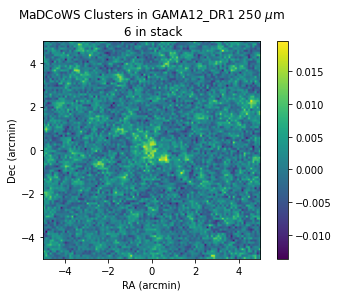

350 GAMA12_DR1


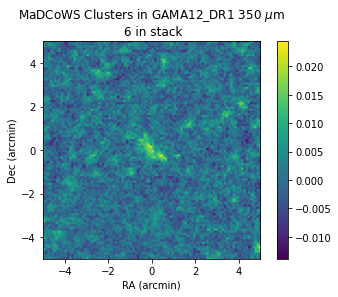

500 GAMA12_DR1


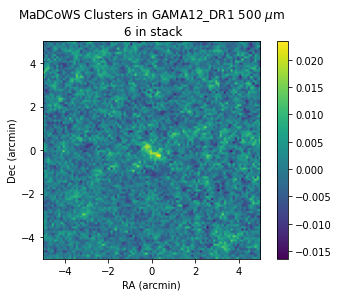

250 GAMA15_DR1


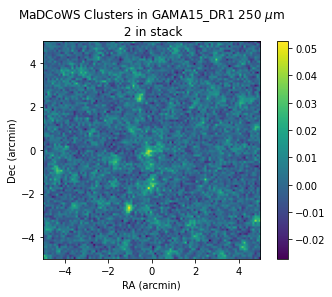

350 GAMA15_DR1


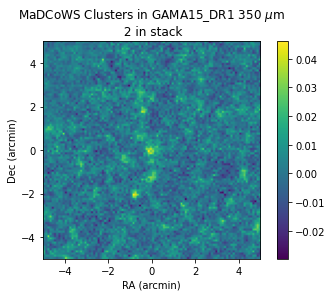

500 GAMA15_DR1


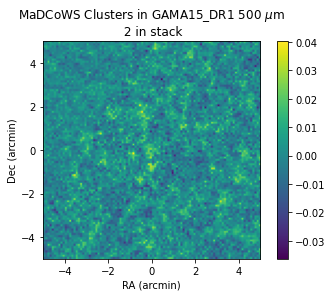

250 GAMA9_DR1


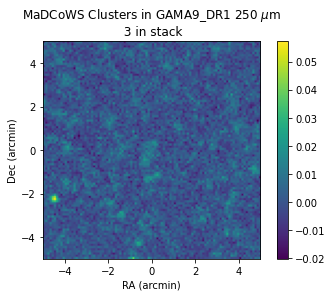

350 GAMA9_DR1


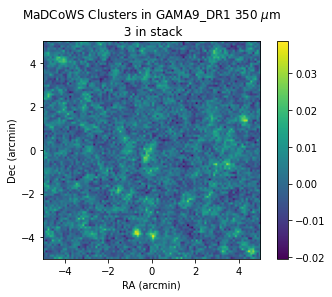

500 GAMA9_DR1


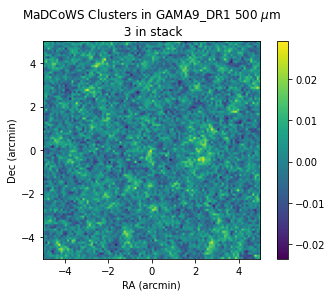

250 NGP_DR2


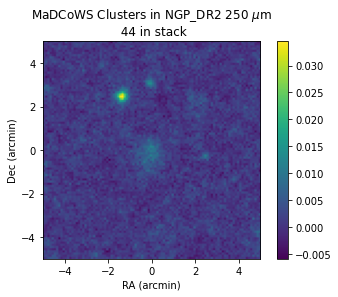

350 NGP_DR2


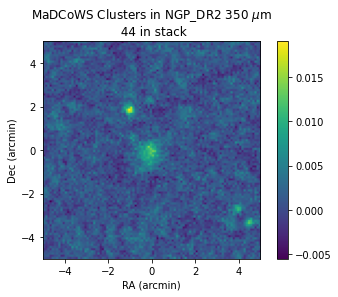

500 NGP_DR2


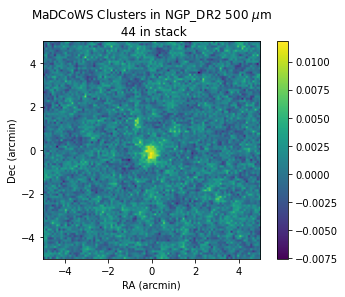

250 SGP_DR2


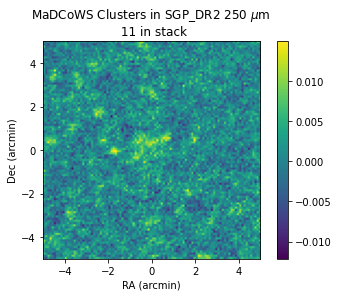

350 SGP_DR2


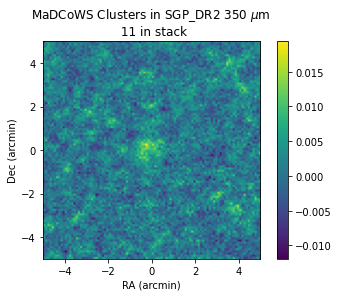

500 SGP_DR2


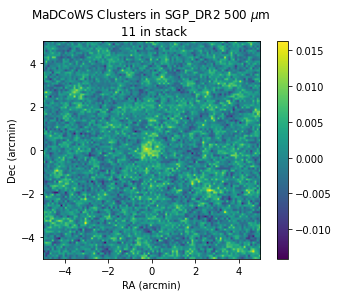

In [14]:
hmaps = ['GAMA12_DR1','GAMA15_DR1', 'GAMA9_DR1', 'NGP_DR2', 'SGP_DR2']
freqs = ['250', '350', '500']

mdcw_catalog = fits.open('/home/s/sievers/sdicker/ACTnCOWs/MADCOWSUnion.fits')

ras = mdcw_catalog[1].data['RADeg']
names = mdcw_catalog[1].data['name']
decs = mdcw_catalog[1].data['decDeg']
ras, decs = np.array(ras), np.array(decs)

for hmap in hmaps:
    for freq in freqs:
        hersch_stacker(hmap, freq, ras, decs, 50.)

In [4]:
hi_data = fits.open('/project/r/rbond/jorlo/herschel_maps/HATLAS/smoothed/HATLAS_NGP_DR2_FILT_BACKSUB500_0.9FILT.fits')
w = wcs.WCS(hi_data[0].header)
print(hi_data[0].header)
hi_data[0].header['CDELT2']*3600*3

print(w.wcs_world2pix(10,10,1))

FileNotFoundError: [Errno 2] No such file or directory: '/project/r/rbond/jorlo/herschel_maps/HATLAS/smoothed/HATLAS_NGP_DR2_FILT_BACKSUB500_0.9FILT.fits'

In [10]:
herschel_ps =  fits.open('/project/r/rbond/jorlo/herschel_maps/HATLAS/HATLAS_NGP_DR2_CATALOGUE_V1.4.FITS')

ras = herschel_ps[1].data['RA']
decs = herschel_ps[1].data['DEC']
ras, decs = np.array(ras), np.array(decs)


250 NGP_DR2


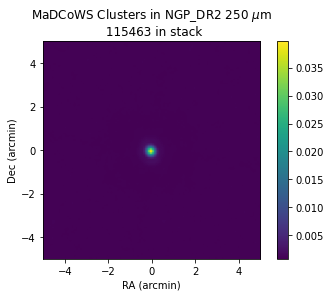

350 NGP_DR2


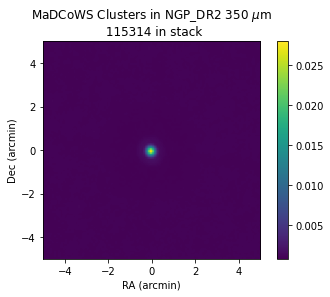

500 NGP_DR2


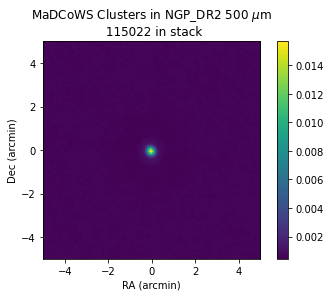

In [11]:

freqs = [ '250', '350', '500']
for freq in freqs:
    hersch_stacker('NGP_DR2', freq, ras, decs, 50.)

/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


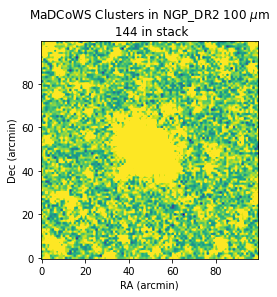

In [153]:
px2, py2 = w.wcs_world2pix(ras[1], decs[1], 1)


px2 = np.round(px2).astype(int)
py2 = np.round(py2).astype(int)

#stamp = hi_data[0].data[px-50: px+50, py-50: py+50]

cutout2 = Cutout2D(hi_data[0].data, (px2,py2), 100)

fig.add_subplot(111, projection=w)
plt.imshow(cutout2.data, origin='lower', cmap=plt.cm.viridis, vmax = 1e-2)
plt.title('MaDCoWS Clusters in {} {} $\mu$m \n {} in stack'.format(hmap, freq, divisor))
plt.xlabel('RA (arcmin)')
plt.ylabel('Dec (arcmin)')
#plt.savefig('./plots/herschel/{}_{}_filtered_mdcw.pdf'.format(hmap, freq))
#plt.savefig('./plots/herschel/{}_{}_filtered_mdcw.png'.format(hmap, freq), dpi = 300)
plt.show()
plt.close()

In [157]:
stack = cutout.data + cutout2.data
stack  /= 2

In [10]:
hmaps = ['GAMA12_DR1','GAMA15_DR1', 'GAMA9_DR1', 'NGP_DR2', 'SGP_DR2']
freqs = ['250', '350', '500']

mdcw_catalog = fits.open('/home/s/sievers/sdicker/ACTnCOWs/MADCOWSUnion.fits')

ras = mdcw_catalog[1].data['RADeg']
names = mdcw_catalog[1].data['name']
decs = mdcw_catalog[1].data['decDeg']
zs = mdcw_catalog[1].data['Photz']
ras, decs = np.array(ras), np.array(decs)

66.0ing map SGP_DR2 250500


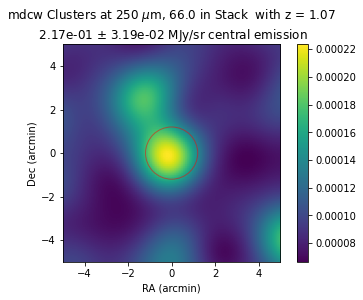

66.0ing map SGP_DR2 350500


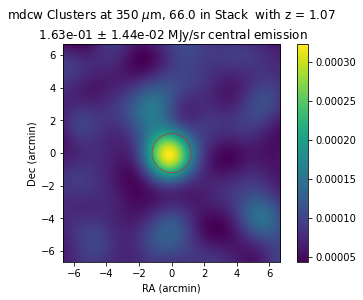

66.0ing map SGP_DR2 500000


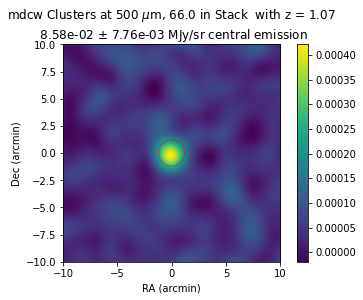

0.53

In [14]:
smooth_stacks = {'250':[], '350':[], '500':[]}
mdcw_stamps = {}

for freq in freqs:
        
    stack, cent, cent_var, HATLAS_names = filt_full_hersch_stacker(freq, ras, decs, 'mdcw', names, width = 50., zs = zs, weight = False)
    smooth_stacks[freq].append(stack)
    
    stamp = hersch_stamper(freq,ras, decs, 50.,names)
    mdcw_stamps[freq] = stamp
    
        
pk.dump(mdcw_stamps, open('mdcw_stamps.pk', 'wb'))

In [45]:
flags = [False for i in range(len(names))] 
#print(flags)
for i in range(len(names)):
    if names[i] in HATLAS_names:
        flags[i] = True


boot_smooth_stacks = {'250':[], '350':[], '500':[]}


for i in range(100):
    print(i, end = '\r')
    flags = np.random.randint(len(ras), size = len(ras))
    
    temp_ras, temp_decs, temp_names, temp_zs = ras[flags], decs[flags], names[flags], zs[flags]


    for freq in freqs:

        stack, cent, cent_var, HATLAS_names = filt_full_hersch_stacker(freq, temp_ras, temp_decs, 'mdcw', temp_names, width = 50., zs = temp_zs, weight = False, plot = False)
        boot_smooth_stacks[freq].append(stack)




pk.dump(boot_smooth_stacks, open('boot_mdcw_stamps.pk', 'wb'))


68.0ing map SGP_DR2 250500
68.0ing map SGP_DR2 350500
68.0ing map SGP_DR2 500000
74.0ing map SGP_DR2 250500
74.0ing map SGP_DR2 350500
74.0ing map SGP_DR2 500000
68.0ing map SGP_DR2 250500
68.0ing map SGP_DR2 350500
68.0ing map SGP_DR2 500000
57.0ing map SGP_DR2 250500
57.0ing map SGP_DR2 350500
57.0ing map SGP_DR2 500000
66.0ing map SGP_DR2 250500
66.0ing map SGP_DR2 350500
66.0ing map SGP_DR2 500000
64.0ing map SGP_DR2 250500
64.0ing map SGP_DR2 350500
64.0ing map SGP_DR2 500000
61.0ing map SGP_DR2 250500
61.0ing map SGP_DR2 350500
61.0ing map SGP_DR2 500000
74.0ing map SGP_DR2 250500
74.0ing map SGP_DR2 350500
74.0ing map SGP_DR2 500000
62.0ing map SGP_DR2 250500
62.0ing map SGP_DR2 350500
62.0ing map SGP_DR2 500000
63.0ing map SGP_DR2 250500
63.0ing map SGP_DR2 350500
63.0ing map SGP_DR2 500000
68.0ing map SGP_DR2 250500
68.0ing map SGP_DR2 350500
68.0ing map SGP_DR2 500000
66.0ing map SGP_DR2 250500
66.0ing map SGP_DR2 350500
66.0ing map SGP_DR2 500000
59.0ing map SGP_DR2 250500
5

In [61]:
cent_means = {'250':[], '350':[], '500':[]}
pixel_scales = {'250': 18/3, '350':25/3, '500':36/3}
for freq in freqs:
    for i in range(len(boot_smooth_stacks[freq])):
        stack = boot_smooth_stacks[freq][i]

        pixel_size = (pixel_scales[freq]*u.arcsec).to(u.arcmin)

        em, num = central_emission(stack, 50, pixel_size.value, 1.2)

        em = em*u.Jy
        em = em.to(u.MJy)

        pixel_area = ((pixel_size)**2).to(u.sr)


        mean_cent_em = em/(num*pixel_area)
        map_var_Jy = np.std(stack[60:99, 0:99]/pixel_area.value)*u.Jy/pixel_area.unit
        map_var = (map_var_Jy).to(u.MJy/u.sr)

        cent_means[freq].append(mean_cent_em.value)

In [65]:
print('250 error: ', np.std(cent_means['250']))
print('350 error: ', np.std(cent_means['350']))
print('500 error: ', np.std(cent_means['500']))

250 error:  0.014517614113100291
350 error:  0.011704590241196891
500 error:  0.0075511613726321


In [10]:
stamps = mdcw_stamps['250']

good_names = []
sigmas = []

beam = 2.4

for key in stamps.keys():
    stamp = stamps[key][0]
    pixel_size = stamps[key][1]*60*u.arcmin
    plt.imshow(stamp)
    #plt.show()
    plt.close()
    
    em, num = central_emission(stamp, 50, pixel_size.value, beam/2)
    em = em*u.Jy
    em = em.to(u.MJy)

    pixel_area = (pixel_size)**2
    pixel_area = pixel_area.to(u.sr)
    
    mean_cent_em = em/(num*pixel_area)
    map_var_Jy = np.std(stamp[60:99, 0:99]/pixel_area.value)*u.Jy/pixel_area.unit
    map_var = (map_var_Jy).to(u.MJy/u.sr) 

    
    if mean_cent_em/map_var > 4:
        print(mean_cent_em/map_var)
        good_names.append(key)  
        sigmas.append(mean_cent_em/map_var)

6.7033143067418735
4.25612823691627
5.025367522374488
5.018497547841789
8.58248404053243
4.271778379774835
4.127729165450579
12.092751389633438
5.731353741913385


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Model: BlackBody
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
       temperature             scale        
            K                 MJy / sr      
    ------------------ ---------------------
    23.857458126389535 1.643260516112612e-07


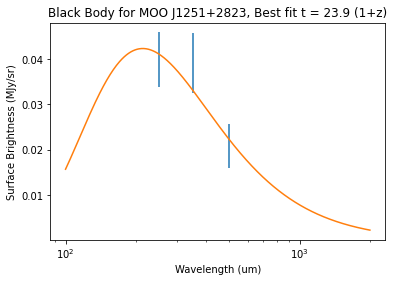

/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/astropy/modeling/powerlaws.py:50: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)


Model: PowerLaw1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
         amplitude             x_0                alpha       
          MJy / sr             GHz                            
    ------------------- ------------------ -------------------
    0.04216800802056307 1209.0844369256022 -0.9038539964446292
[5.21463697e+00 8.18230665e-08] sr2 / MJy2


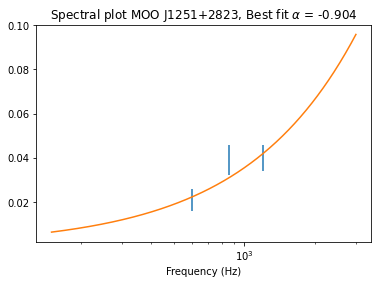

Model: BlackBody
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
       temperature             scale         
            K                 MJy / sr       
    ------------------ ----------------------
    367.79524545768555 1.8008117151959136e-09


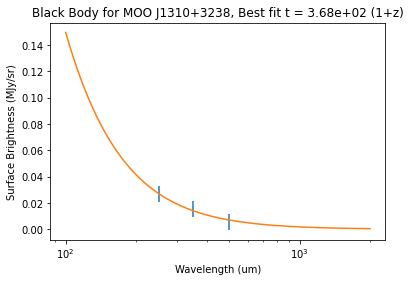

Model: PowerLaw1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude               x_0                  alpha       
         MJy / sr               GHz                              
    ------------------ ---------------------- -------------------
    0.6079936529220221 4.5727350076487116e-10 0.13157078183409257


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/astropy/modeling/powerlaws.py:50: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)


ValueError: Input must be 1- or 2-d.

In [11]:
ts = []
indecies = []
t_errs = []

for name in good_names:
    MJys = []
    MJys_err = []
    fit_freqs = np.array([250, 350, 500])*u.um
    
    for freq in ['250', '350', '500']:
        stamps = mdcw_stamps[freq]
        stamp, pixel_size = stamps[name][0], stamps[name][1]*60*u.arcmin
        
        em, num = central_emission(stamp, 50, pixel_size.value, beam/2)
        em = em*u.Jy
        em = em.to(u.MJy)

        pixel_area = (pixel_size)**2
        pixel_area = pixel_area.to(u.sr)

        mean_cent_em = em/(num*pixel_area)
        map_var_Jy = np.std(stamp[60:99, 0:99]/pixel_area.value)*u.Jy/pixel_area.unit
        map_var = (map_var_Jy).to(u.MJy/u.sr) 
        
        MJys_err.append(map_var.value)
        MJys.append(mean_cent_em.value)
        
    MJys = np.array(MJys)*u.MJy/u.sr
    model = models.BlackBody(temperature = 100*u.K, scale = 1e-8 * u.MJy/u.sr)
    fitter = fitting.LevMarLSQFitter()
    MJys_err = np.array(MJys_err)*u.MJy/u.sr

    
    best_fit = fitter(model, fit_freqs, MJys, weights=1.0/MJys_err**2)
    #scales.append(best_fit.scale.value)
    print(best_fit)
    try:
        cov_diag = np.diag(fitter.fit_info['param_cov'])
    except:
        cov_diag = [0*u.K]
    
    
    

    wav = np.arange(100, 2000) * u.um
    flux = best_fit(wav).to(u.MJy/u.sr)


    plt.figure()
    plt.title('Black Body for {}, Best fit t = {:0.3} (1+z)'.format(name, best_fit.temperature.value))
    plt.errorbar(fit_freqs.value, MJys.value, yerr = MJys_err.value, linestyle = 'none')
    plt.semilogx(wav, flux)
    
    plt.xlabel('Wavelength (um)')
    plt.ylabel("Surface Brightness (MJy/sr)")
    #plt.axvline(bb.nu_max.to(u.um, equivalencies=u.spectral()).value, ls='--')

    
    plt.savefig('./plots/herschel/indv_clusters/blackbody_{}.pdf'.format(name))
    plt.savefig('./plots/herschel/indv_clusters/blackbody_{}.png'.format(name), dpi = 300)
    
    plt.show()
    plt.close
    
    ts.append(best_fit.temperature.value)
    t_errs.append(cov_diag[0].value)
    
    #Fit for spectral index
    power_law = models.PowerLaw1D(x_0 = 2000)
    fit = fitting.LevMarLSQFitter()
    fitted_power = fit(power_law,fit_freqs.to(u.GHz, equivalencies=u.spectral()), MJys, weights=1.0/MJys_err**2)
                      
    print(fitted_power)
    
    cov_diag = np.diag(fitter.fit_info['param_cov'])
    print(np.sqrt(cov_diag))
    
    wav = np.arange(100, 2000) * u.um
    wav = wav.to(u.GHz, equivalencies=u.spectral())
    flux = fitted_power(wav)


    plt.figure()
    plt.title(r'Spectral plot {}, Best fit $\alpha$ = {:0.3} '.format(name, fitted_power.alpha.value))
    plt.errorbar(fit_freqs.to(u.GHz, equivalencies=u.spectral()).value, MJys.value, yerr = MJys_err.value, linestyle = 'none')
    plt.semilogx(wav, flux)
    
    plt.xlabel('Frequency (Hz)')
    
    #plt.axvline(bb.nu_max.to(u.um, equivalencies=u.spectral()).value, ls='--')

    
    plt.savefig('./plots/herschel/indv_clusters/spectral_{}.pdf'.format(name))
    plt.savefig('./plots/herschel/indv_clusters/spectral_{}.png'.format(name), dpi = 300)
    
    plt.show()
    plt.close

In [316]:
print(good_names,sigmas, ts)

['MOO J1454+0032', 'MOO J1251+2823', 'MOO J1254+3320', 'MOO J1256+2537', 'MOO J1310+3238', 'MOO J1319+2252', 'MOO J1321+2711', 'MOO J1322+3134', 'MOO J1327+2317', 'MOO J1333+2900', 'MOO J1335+3004', 'MOO J1337+3529', 'MOO J1340+3011', 'MOO J1344+2826', 'MOO J1247+3430', 'MOO J1328+3305', 'MOO J0118-2714', 'MOO J0127-2759', 'MOO J0139-3120'] [<Quantity 4.3201912>, <Quantity 8.07561799>, <Quantity 4.19252924>, <Quantity 4.87153639>, <Quantity 4.69597901>, <Quantity 5.66604954>, <Quantity 4.51179547>, <Quantity 4.35347974>, <Quantity 4.83826277>, <Quantity 6.80957386>, <Quantity 10.80070189>, <Quantity 4.24018245>, <Quantity 4.27802407>, <Quantity 4.90470917>, <Quantity 4.83422833>, <Quantity 5.2481736>, <Quantity 11.71072614>, <Quantity 6.52618126>, <Quantity 4.49094005>] [3093.6902458619393, 49.902465981369524, 19.34349390635666, 6347.211594942679, 2930.2377386072912, 1775.021769938699, 31.85719200991918, 44.71506294213962, 2291.8103339814343, 212.76545699517987, 29.035611026760066, 69.

0.001666666666667
0.10000000000002 arcmin
8.280452931649052e-08 MJy 448 8.461594994078622e-10 sr
0.002222222222222
0.13333333333332 arcmin
6.291553810297046e-08 MJy 256 1.5042835545019638e-09 sr
0.003333333333333
0.19999999999998 arcmin
3.25097552704392e-08 MJy 112 3.384637997629418e-09 sr
[0.00701    0.21843581 0.16337599 0.08575974] MJy / sr


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Model: BlackBody
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
       temperature            scale         
            K                MJy / sr       
    ----------------- ----------------------
    68.32072300079105 1.4157544758021109e-07


NameError: name 'name' is not defined

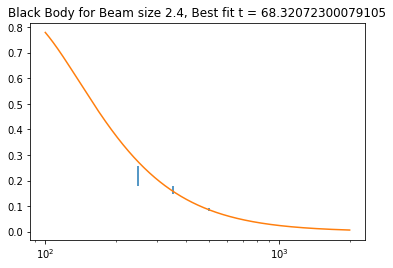

In [9]:
#beams = np.linspace(0.4, 1.5, 10)

beams = [2.4]

infered_t = []
infered_t_err = []

scales = []

for beam in beams:
    MJys = [0.00701]
    MJys_err = np.array([0.000967, 0.0384, 0.0144, 0.00608])*u.MJy/u.sr
    fit_freqs = np.array([1362.69, 250, 350, 500])*u.um
    
    for freq in freqs:

        hi_data = fits.open('/project/r/rbond/jorlo/herschel_maps/HATLAS/smoothed/HATLAS_SGP_DR2_FILT_BACKSUB{}_1.0SMOOTH.fits'.format(freq))
        header = hi_data[0].header
        
        cdelt = header.get('CDELT2', 1.0)
        print(cdelt)
        pixel_size = cdelt*60*u.arcmin
        
        print(pixel_size)
        em, num = central_emission(smooth_stacks[freq][0], 50, pixel_size.value, beam/2)
        em = em*u.Jy
        em = em.to(u.MJy)
        
        pixel_area = ((pixel_size)**2).to(u.sr)
        print(em, num, pixel_area)
        MJys.append((em/(num*pixel_area)).value)
        #print('Emission at {}: {}'.format(freq,em/area))
    MJys = np.array(MJys)*u.MJy/u.sr
    model = models.BlackBody(temperature = 100*u.K, scale = 1e-8 * u.MJy/u.sr)
    fitter = fitting.LevMarLSQFitter()
    print(MJys)
    
    cut = 1
    
    best_fit = fitter(model, fit_freqs[cut:], MJys[cut:], weights=1.0/MJys_err[cut:]**2)
    scales.append(best_fit.scale.value)
    infered_t.append(best_fit.temperature.value)
    print(best_fit)
    #cov_diag = np.diag(fitter.fit_info['param_cov'])
    #infered_t_err.append(np.sqrt(cov_diag)[0].value)
    
    

    wav = np.arange(100, 2000) * u.um
    flux = best_fit(wav).to(u.MJy/u.sr)


    plt.figure()
    plt.title('Black Body for Beam size {}, Best fit t = {}'.format(beam, best_fit.temperature.value))
    plt.errorbar(fit_freqs.value, MJys.value, yerr = MJys_err.value, linestyle = 'none')
    plt.semilogx(wav, flux)
    #plt.axvline(bb.nu_max.to(u.um, equivalencies=u.spectral()).value, ls='--')
    plt.savefig('./plots/herschel/indv_clusters/blackbody_{}.pdf'.format(name))
    plt.savefig('./plots/herschel/indv_clusters/blackbody_{}.png'.format(name), dpi = 300)
    
    plt.show()
    plt.close

    #Fit powerlaw
    power_law = models.PowerLaw1D(x_0 = 2000)
    fit = fitting.LevMarLSQFitter()
    print(fit_freqs.to(u.GHz, equivalencies=u.spectral()))
    fitted_power = fit(power_law,fit_freqs.to(u.GHz, equivalencies=u.spectral())[cut:], MJys[cut:], weights=1.0/MJys_err[cut:]**2)
                      
    print(fitted_power)
    
    
    wav = np.arange(200, 600) * u.um
    wav = wav.to(u.GHz, equivalencies=u.spectral())
    flux = fitted_power(wav)
    #cov_diag = np.diag(fit.fit_info['param_cov'])
    print(fit.fit_info['param_cov'])

    plt.figure()
    plt.title(r'MaDCoWS Spectral plot, Best fit $\alpha$ = {:0.3}, Appeture size = {} '.format(fitted_power.alpha.value, beam))
    plt.errorbar(fit_freqs.to(u.GHz, equivalencies=u.spectral()).value[cut:], MJys.value[cut:], yerr = MJys_err.value[cut:], linestyle = 'none')
    plt.semilogx(wav, flux)
    
    plt.xlabel('Frequency (Hz)')
    
    #plt.axvline(bb.nu_max.to(u.um, equivalencies=u.spectral()).value, ls='--')

    plt.xlim()
    plt.savefig('./plots/herschel/mdcw_spectral.pdf')
    plt.savefig('./plots/herschel/mdcw_spectral.png', dpi = 300)
    
    plt.show()
    plt.close

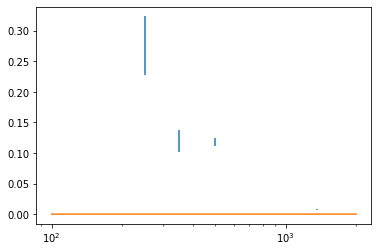

In [235]:
bb = models.BlackBody(temperature=infered_t*u.K, scale = scales)

wav = np.arange(100, 2000) * u.um
flux = bb(wav).to(u.MJy/u.sr)


plt.figure()
plt.errorbar(fit_freqs.value, MJys.value, yerr = MJys_err.value, linestyle = 'none')
plt.semilogx(wav, flux)
#plt.axvline(bb.nu_max.to(u.um, equivalencies=u.spectral()).value, ls='--')
plt.show()

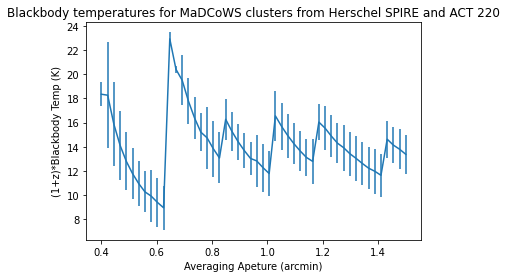

In [145]:

plt.errorbar(beams, infered_t, yerr = infered_t_err)
plt.xlabel('Averaging Apeture (arcmin)')
plt.ylabel('(1+z)*Blackbody Temp (K)')
plt.title('Blackbody temperatures for MaDCoWS clusters from Herschel SPIRE and ACT 220')
plt.savefig('./plots/herschel/blackbody.pdf')
plt.savefig('./plots/herschel/blackbody.png', dpi = 300)
plt.show()

In [41]:
act_catalog = fits.open('/gpfs/fs0/project/r/rbond/jorlo/cluster_catalogs/DR5_cluster-catalog_v1.0b2.fits')

ras_act = act_catalog[1].data['RADeg']
names_act = act_catalog[1].data['name']
decs_act = act_catalog[1].data['decDeg']
act_zs = act_catalog[1].data['redshift']
mass = act_catalog[1].data['M500']

33.0


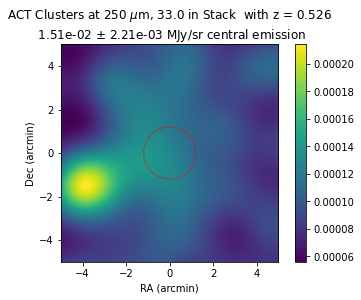

34.0


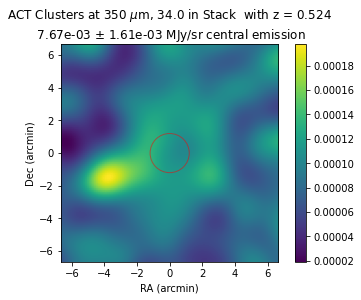

34.0


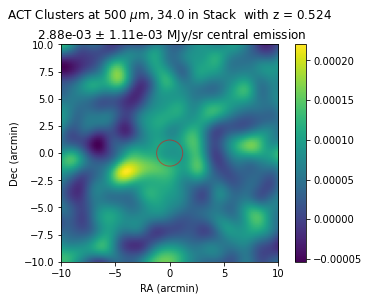

In [42]:
act_smooth_stacks = {'250':[], '350':[], '500':[]}

for freq in freqs:
        
    stack, cent, cent_var = filt_full_hersch_stacker(freq, ras_act, decs_act, 'ACT', width = 50., weight = False, zs = act_zs)
    act_smooth_stacks[freq].append(stack)
        

In [143]:
beams = np.linspace(0.4, 1, 20)

act_infered_t = []
act_infered_t_err = []

for beam in beams:
    MJys = []
    MJys_err = np.array([ 0.0253, 0.0159, 0.00837])*u.MJy/u.sr
    fit_freqs = np.array([250, 350, 500])*u.um
    
    for freq in freqs:

        hi_data = fits.open('/project/r/rbond/jorlo/herschel_maps/HATLAS/smoothed/HATLAS_SGP_DR2_FILT_BACKSUB{}_0.9SMOOTH.fits'.format(freq))


        w = wcs.WCS(hi_data[0].header)
        
        header = hi_data[0].header

        cdelt = header.get('CDELT2', 1.0)

        pixel_size = cdelt*60*u.arcmin

        em = central_emission(act_smooth_stacks[freq][0], 50, pixel_size, beam/2)[0]*u.Jy
        em = em.to(u.MJy)
        area = (np.pi*(beam*u.arcmin)**2).to(u.sr)
        MJys.append((em/area).value)
        #print('Emission at {}: {}'.format(freq,em/area))
    MJys = np.array(MJys)*u.MJy/u.sr
    model = models.BlackBody(temperature = 100*u.K, scale = 1e-5 * u.MJy/u.sr)
    fitter = fitting.LevMarLSQFitter()

    best_fit = fitter(model, fit_freqs, MJys, weights=1.0/MJys_err**2)
    print(best_fit)
    act_infered_t.append(best_fit.temperature.value)
    cov_diag = np.diag(fitter.fit_info['param_cov'])
    act_infered_t_err.append(np.sqrt(cov_diag)[0].value)


Model: BlackBody
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
       temperature            scale         
            K                MJy / sr       
    ----------------- ----------------------
    7.470296030283695 1.3884585886701772e-06
Model: BlackBody
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
       temperature            scale        
            K                MJy / sr      
    ----------------- ---------------------
    7.470689607864779 1.388295093851462e-06
Model: BlackBody
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
       temperature            scale        
            K                MJy / sr      
    ----------------- ---------------------
    6.928129407354526 1.603047118002794e-06
Model: BlackBody
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
       temperature            scale         
            K                MJy / sr       
    ----------------- ----------------------
    6.500507300500477

ValueError: Input must be 1- or 2-d.

In [34]:
act_catalog[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2478 / length of dimension 1                          
NAXIS2  =                 4195 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   50 / number of table fields                         
TTYPE1  = 'name    '                                                            
TFORM1  = '19A     '                                                            
TTYPE2  = 'RADeg   '                                                            
TFORM2  = 'D       '                                                            
TTYPE3  = 'decDeg  '        

In [11]:
        hi_data = fits.open('/project/r/rbond/jorlo/herschel_maps/HATLAS/smoothed/HATLAS_NGP_DR2_FILT_BACKSUB250_1.0SMOOTH.fits')

In [15]:
header = hi_data[0].header

print(header)

SIMPLE  =                    T / Written by IDL:  Wed Dec  6 18:28:26 2017      BITPIX  =                  -32                                                  NAXIS   =                    2                                                  NAXIS1  =                 9562                                                  NAXIS2  =                 8694                                                  CTYPE1  = 'RA---TAN'                                                            CTYPE2  = 'DEC--TAN'                                                            CRVAL1  = 197.9929459955868083                                                  CDELT1  =   -0.001666666666667                                                  CRPIX1  =                 5572                                                  CRVAL2  =  26.0900597940217409                                                  CDELT2  =    0.001666666666667                                                  CRPIX2  =                 2466          

In [18]:
header.get('CTYPE1')
header.get('CRVAL1')

'RA---TAN'